<a href="https://colab.research.google.com/github/SatoshiEndoDEV/colab_sample/blob/main/signate_565music_LGBM%2BkNN_cv5%2Bpop10_region%2BTE%2BGMM_2_hm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LGBM+kNN


cv5に変更

FE追加
* popularityを10の位で分類しなおし、regionとgroupbyして集約特徴量を生成する
* 各特徴量を0.1刻みなどに丸めてみる


CVアンサンブルを調和平均に変更

target count encodingを追加

Gaussian Mixture Model(GMM)を特徴量に追加：kfold内で処理

#signate CLI接続

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install signate

APIトークンを保存

In [3]:
! mkdir -p /root/.signate && cp /content/drive/MyDrive/signate/.signate/signate.json /root/.signate/

#ファイルダウンロード

In [4]:
! signate download -c 565

genre_labels.csv

sample_submit.csv

test.csv

train.csv


Download completed.


#ライブラリ

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

In [6]:
N_CLASSES = 11

In [7]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
df_sample_sub = pd.read_csv('/content/sample_submit.csv', header=None)
df_sample_sub.columns = ["index", "genre"]
df_genre_labels = pd.read_csv('/content/genre_labels.csv')

In [8]:
def merge_train_test(df_train, df_test):
    if "genre" not in df_test.columns.tolist():
        df_test["genre"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

In [9]:
def split_train_test(df):
    df_train = df[df["genre"] != -100]
    df_test = df[df["genre"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

In [10]:
df = merge_train_test(df_train, df_test)

#feature engineering

In [11]:
df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)

欠損値補完

In [12]:
from sklearn.impute import KNNImputer

df_na = df.isnull().sum()
df_na = df_na[df_na!=0].index.tolist()

df_param=KNNImputer().fit_transform(df.loc[:,df_na].copy())
df_param = pd.DataFrame(df_param)

for i, _ in enumerate(df_na):
    df.loc[:,df_na[i]]=df_param[i]



*   region+popularity10で集約
*   特徴項目を0.1刻みに分類



In [13]:
df['popularity10'] = df['popularity']//10

In [14]:
origin = ['duration_ms',
         'acousticness',
         'positiveness',
         'danceability',
         'loudness',
         'energy',
         'liveness',
         'speechiness',
         'instrumentalness',
]

In [15]:
for o in origin:
    df[f"{o}_mean"] = df.groupby(["region", "popularity10"]).transform(np.mean)[f"{o}"]
    df[f"{o}_median"] = df.groupby(["region", "popularity10"]).transform(np.median)[f"{o}"]
    df[f"{o}_max"] = df.groupby(["region", "popularity10"]).transform(np.max)[f"{o}"]
    df[f"{o}_min"] = df.groupby(["region", "popularity10"]).transform(np.min)[f"{o}"]
    df[f"{o}_25"] = df.groupby(["region", "popularity10"]).transform(lambda x: np.percentile(x, q=0.25))[f"{o}"]
    df[f"{o}_75"] = df.groupby(["region", "popularity10"]).transform(lambda x: np.percentile(x, q=0.75))[f"{o}"]
    df[f"{o}_zscore"] = df.groupby(["region", "popularity10"]).transform(lambda x: (x-np.mean(x))/np.std(x))[f"{o}"]

In [16]:
origin10 = ['duration_ms',
         'acousticness',
         'positiveness',
         'danceability',
         'energy',
         'liveness',
         'speechiness',
         'instrumentalness',
]

In [17]:
for o in origin10:
    exec(f'df["{o+str(10)}"]=df["{o}"]//0.1')

In [18]:
df["loudness10"] = round(np.abs(df["loudness"]))

target count encoding

In [19]:
#genreでone hot encoding
#ohe = pd.get_dummies(df['genre'], prefix='genre')

In [20]:
#genre_-100は使用しないので削除
#ohe.drop(['genre_-100'], axis =1, inplace=True)

In [21]:
#df = df.join(ohe)

In [22]:
#genre_1 ,,, でカウント
#for i in range(11):
#    df[f'genre_{i}_tce'] = df.groupby(["region", "popularity10"]).transform(np.sum)[f'genre_{i}'].astype('int')

In [23]:
#for j in range(11):
#    df.drop([f'genre_{j}'], axis=1, inplace=True)

testにもtceが反映されているのでリークかも

kNN特徴量生成

In [24]:
df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))

In [25]:
df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"})], axis=1)

In [26]:
df["num_nans"] = 0
for col in [
    "acousticness",
    "positiveness",
    "danceability",
    "energy",
    "liveness",
    "speechiness",
    "instrumentalness",
]:
    df["num_nans"] += df[col].isna()

In [27]:
class CountEncoder:
    def fit(self, series):
        self.counts = series.groupby(series).count()
        return self
    
    def transform(self, series):
        return series.map(self.counts).fillna(0)
    
    def fit_transform(self, series):
        return self.fit(series).transform(series)

In [28]:
columns_count_enc = ["region"]
for col in columns_count_enc:
    df["countenc_" + col] = CountEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "countenc_" + col] = np.nan

In [29]:
columns_label_enc = ["region"]
for col in columns_count_enc:
    df["labelenc_" + col] = LabelEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "labelenc_" + col] = np.nan

In [30]:
class GroupFeatureExtractor:  # 参考: https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    EX_TRANS_METHODS = ["deviation", "zscore"]
    
    def __init__(self, group_key, group_values, agg_methods):
        self.group_key = group_key
        self.group_values = group_values

        self.ex_trans_methods = [m for m in agg_methods if m in self.EX_TRANS_METHODS]
        self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
        self.df_agg = None

    def fit(self, df_train, y=None):
        if not self.agg_methods:
            return
        dfs = []
        for agg_method in self.agg_methods:
            if callable(agg_method):
                agg_method_name = agg_method.__name__
            else:
                agg_method_name = agg_method
            df_agg = (df_train[[self.group_key] + self.group_values].groupby(self.group_key).agg(agg_method))
            df_agg.columns = self._get_column_names(agg_method_name)
            dfs.append(df_agg)
        self.df_agg = pd.concat(dfs, axis=1).reset_index()

    def transform(self, df_eval):
        key = self.group_key
        if self.agg_methods:
            df_features = pd.merge(df_eval[[self.group_key]], self.df_agg, on=self.group_key, how="left")
        else:
            df_features = df_eval[[self.group_key]].copy()
        if self.ex_trans_methods:
            if "deviation" in self.ex_trans_methods:
                df_features[self._get_agg_column_names("deviation")] = df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")
            if "zscore" in self.ex_trans_methods:
                df_features[self._get_column_names("zscore")] = (df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")) \
                                                                / (df_eval[[key]+self.group_values].groupby(key).transform("std") + 1e-8)
        df_features.drop(self.group_key, axis=1, inplace=True)
        return df_features

    def _get_column_names(self, method):
        return [f"agg_{method}_{col}_grpby_{self.group_key}" for col in self.group_values]

    def fit_transform(self, df_train, y=None):
        self.fit(df_train, y=y)
        return self.transform(df_train) 

In [31]:
df["log_tempo"] = np.log(df["tempo"])

In [32]:
gfe = GroupFeatureExtractor(
    "region", 
    ['popularity', 'duration_ms', 'acousticness', 'positiveness', 'danceability', 'loudness', 'energy', 'liveness', 'speechiness', 'instrumentalness', 'log_tempo'],
    ["zscore"]
)

In [33]:
df = pd.concat([df, gfe.fit_transform(df)], axis=1)

In [34]:
class KNNFeatureExtractor:
    def __init__(self, n_neighbors=5):
        self.knn = KNeighborsClassifier(n_neighbors + 1)
    
    def fit(self, X, y):
        self.knn.fit(X, y)
        self.y = y if isinstance(y, np.ndarray) else np.array(y)
        return self
    
    def transform(self, X, is_train_data):
        distances, indexes = self.knn.kneighbors(X)
        distances = distances[:, 1:] if is_train_data else distances[:, :-1]
        indexes = indexes[:, 1:] if is_train_data else indexes[:, :-1]
        labels = self.y[indexes]
        score_columns = [f"knn_score_class{c:02d}" for c in range(N_CLASSES)]
        df_knn = pd.DataFrame(
            [np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)],
            columns=score_columns
        )
        df_knn["max_knn_scores"] = df_knn.max(1)
        for col in score_columns:
            df_knn[f"sub_max_knn_scores_{col}"] = df_knn["max_knn_scores"] - df_knn[col]
        for i, col1 in enumerate(score_columns):
            for j, col2 in enumerate(score_columns[i+1:], i+1):
                if {i, j} & {8, 10}:
                    df_knn[f"sub_{col1}_{col2}"] = df_knn[col1] - df_knn[col2]
        df_knn["sum_knn_scores"] = df_knn.sum(1)
        
        return df_knn

feature scaling

In [35]:
df["log_tempo"] = np.log(df["tempo"])
for col in [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 'log_tempo', 'num_nans',
]:
    df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]

label encoding

In [36]:
categorical = df.dtypes[df.dtypes=='object'].index.tolist()

In [37]:
#label encoder
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

for c in categorical:
    c2l = df.loc[:,c]
    c2l = le.fit_transform(c2l)
    df.loc[:,c] = c2l 

最後にもう一度欠損値補完

In [38]:
df_na = df.isnull().sum()
df_na = df_na[df_na!=0].index.tolist()

df_param=KNNImputer().fit_transform(df.loc[:,df_na].copy())
df_param = pd.DataFrame(df_param)

for i, _ in enumerate(df_na):
    df.loc[:,df_na[i]]=df_param[i]

df_train df_test 分割

In [39]:
df_train, df_test = split_train_test(df)

In [40]:
target = df_train["genre"]

#parameters

In [41]:
learning_rate = 0.01

In [42]:
lgb_params = {
    "objective": "multiclass",
    "num_class": N_CLASSES,
    #"metric": "None",
    "learning_rate": learning_rate,
    "num_leaves": 3,
    "min_data_in_leaf": 40,
    #"colsample_bytree": 1.0,
    #"feature_fraction": 1.0,
    #"bagging_freq": 0,
    #"bagging_fraction": 1.0,
    "verbosity": 0,
    "seed": 42,
}

In [43]:
knn_n_neighbors = 6

In [44]:
knn_features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'region_unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'standardscaled_log_tempo', 'standardscaled_num_nans'
]

In [45]:
dict_feature_weights = {}
for col in [
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
    'region_S', 'region_T', 'region_unknown'
]:
    dict_feature_weights[col] = 100.0

In [46]:
for col in [
    'standardscaled_duration_ms',
    'standardscaled_acousticness', 'standardscaled_positiveness',
    'standardscaled_danceability', 'standardscaled_loudness',
    'standardscaled_energy', 'standardscaled_liveness',
    'standardscaled_speechiness', 'standardscaled_instrumentalness'
]:
    dict_feature_weights[col] = 1.0

In [47]:
dict_feature_weights["standardscaled_popularity"] = 8.0
dict_feature_weights["standardscaled_log_tempo"] = 0.001
dict_feature_weights["standardscaled_num_nans"] = 100.0

In [48]:
knn_feature_weights = np.array([dict_feature_weights[col] for col in knn_features])

#モデリング＆予測

In [49]:
# GMM
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import AgglomerativeClustering

In [50]:
N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
oof = np.zeros((len(df_train), N_CLASSES))
predictions = np.zeros((len(df_test), N_CLASSES))
df_feature_importance = pd.DataFrame()


features_categorical = ["labelenc_region"]
#features = features_numerical + features_categorical

for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
    print(f"------------------------------ fold {fold_} ------------------------------")
    
    df_trn = df_train.loc[indexes_trn,:].reset_index(drop=True)
    df_val = df_train.loc[indexes_val,:].reset_index(drop=True)
    target_trn = target[indexes_trn].reset_index(drop=True)
    target_val = target[indexes_val].reset_index(drop=True)
    
    # make knn features
    X = df_trn[knn_features].fillna(0.0).values * knn_feature_weights
    knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target_trn)
    df_trn = pd.concat([df_trn, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)
    X = df_val[knn_features].fillna(0.0).values * knn_feature_weights
    df_val = pd.concat([df_val, knn_feature_extractor.transform(X, is_train_data=False)], axis=1)
    X = df_test[knn_features].fillna(0.0).values * knn_feature_weights
    df_test_knn_features = knn_feature_extractor.transform(X, is_train_data=False)
    for col in df_test_knn_features.columns:
        df_test[col] = df_test_knn_features[col]

    # columnsを整理
    features = df_trn.columns.tolist()
    features.remove("index")
    features.remove("genre")
    features.remove("region")
    features.remove("genre_name")
    
    # GMM feature
    model_GMM = GaussianMixture(n_components=11, reg_covar=1e-4)
    model_GMM.fit(df_trn[features])
    trn_GMM = model_GMM.predict(df_trn[features])
    val_GMM = model_GMM.predict(df_val[features])
    tst_GMM = model_GMM.predict(df_test[features])
    
    # DBSCAN
    model_DBSCAN = DBSCAN(eps=20)
    trn_DBSCAN = model_DBSCAN.fit_predict(df_trn[features])
    val_DBSCAN = model_DBSCAN.fit_predict(df_val[features])
    tst_DBSCAN = model_DBSCAN.fit_predict(df_test[features])
    
    # mean shift
    model_MS = MeanShift()
    model_MS.fit(df_trn[features])
    trn_MS = model_MS.predict(df_trn[features])
    val_MS = model_MS.predict(df_val[features])
    tst_MS = model_MS.predict(df_test[features])
    
    # AgglomerativeClustering
    model_AC = AgglomerativeClustering(n_clusters=11)
    trn_AC = model_AC.fit_predict(df_trn[features])
    val_AC = model_AC.fit_predict(df_val[features])
    tst_AC = model_AC.fit_predict(df_test[features])

    # クラスタリング項目を連結
    df_trn['GMM']=trn_GMM
    df_val['GMM']=val_GMM
    df_test['GMM']=tst_GMM
    
    df_trn['DBSCAN']=trn_DBSCAN
    df_val['DBSCAN']=val_DBSCAN
    df_test['DBSCAN']=tst_DBSCAN

    df_trn['MeanShift']=trn_MS
    df_val['MeanShift']=val_MS
    df_test['MeanShift']=tst_MS

    df_trn['AgglomerativeClustering']=trn_AC
    df_val['AgglomerativeClustering']=val_AC
    df_test['AgglomerativeClustering']=tst_AC       

    # featuresにクラスタリングを追加
    features += ['GMM','DBSCAN','MeanShift','AgglomerativeClustering']

    # lgb datasets
    lgb_train = lgb.Dataset(
        df_trn.loc[:, features],
        label=target_trn,
        feature_name=features,
        categorical_feature=features_categorical
    )
    lgb_valid = lgb.Dataset(
        df_val.loc[:, features],
        label=target_val,
        feature_name=features,
        categorical_feature=features_categorical
    )
    
    # modeling
    lgb_params["learning_rate"] = learning_rate + np.random.random() * 0.001  # おまじない
    num_round = 999999999
    model = lgb.train(
        lgb_params,
        lgb_train, 
        num_round, 
        valid_sets=[lgb_train, lgb_valid], 
        verbose_eval=300,
        early_stopping_rounds=300 if num_round >= 1e8 else None,
        fobj=None,
        #feval=lgb_metric,
    )
    
    # cv
    prediction_round = model.best_iteration+150 if num_round >= 1e8 else num_round  # おまじない
    oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)
    
    # feature importance
    df_fold_importance = pd.DataFrame()
    df_fold_importance["feature"] = features
    df_fold_importance["importance"] = model.feature_importance()
    df_fold_importance["fold"] = fold_
    df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)
    
    # prediction for test data
    p = model.predict(df_test[features], num_iteration=prediction_round)
    predictions +=  1/p

predictions = N_SPLITS / predictions
print()

------------------------------ fold 0 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.804814	valid_1's multi_logloss: 0.934665
[600]	training's multi_logloss: 0.714969	valid_1's multi_logloss: 0.877168
[900]	training's multi_logloss: 0.664473	valid_1's multi_logloss: 0.854655
[1200]	training's multi_logloss: 0.627653	valid_1's multi_logloss: 0.846272
[1500]	training's multi_logloss: 0.596879	valid_1's multi_logloss: 0.843717
[1800]	training's multi_logloss: 0.570283	valid_1's multi_logloss: 0.842444
Early stopping, best iteration is:
[1723]	training's multi_logloss: 0.576761	valid_1's multi_logloss: 0.842153
------------------------------ fold 1 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.817113	valid_1's multi_logloss: 0.850557
[600]	training's multi_logloss: 0.72508	valid_1's multi_logloss: 0.798288
[900]	training's multi_logloss: 0.673866	valid_1's multi_logloss: 0.787419
[1200]	training's multi_logloss: 0.636358	valid_1's multi_logloss: 0.784363
Early stopping, best iteration is:
[1176]	training's multi_logloss: 0.63906	valid_1's multi_logloss: 0.784181
------------------------------ fold 2 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.814862	valid_1's multi_logloss: 0.856186
[600]	training's multi_logloss: 0.723696	valid_1's multi_logloss: 0.809365
[900]	training's multi_logloss: 0.673368	valid_1's multi_logloss: 0.794235
[1200]	training's multi_logloss: 0.635773	valid_1's multi_logloss: 0.78759
[1500]	training's multi_logloss: 0.605176	valid_1's multi_logloss: 0.785711
Early stopping, best iteration is:
[1485]	training's multi_logloss: 0.606573	valid_1's multi_logloss: 0.785515
------------------------------ fold 3 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.819329	valid_1's multi_logloss: 0.802037
[600]	training's multi_logloss: 0.72889	valid_1's multi_logloss: 0.757629
[900]	training's multi_logloss: 0.676687	valid_1's multi_logloss: 0.73779
[1200]	training's multi_logloss: 0.639438	valid_1's multi_logloss: 0.728312
[1500]	training's multi_logloss: 0.608162	valid_1's multi_logloss: 0.724225
[1800]	training's multi_logloss: 0.580383	valid_1's multi_logloss: 0.722669
[2100]	training's multi_logloss: 0.555461	valid_1's multi_logloss: 0.72187
[2400]	training's multi_logloss: 0.533077	valid_1's multi_logloss: 0.72233
Early stopping, best iteration is:
[2118]	training's multi_logloss: 0.554029	valid_1's multi_logloss: 0.721625
------------------------------ fold 4 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.809825	valid_1's multi_logloss: 0.841048
[600]	training's multi_logloss: 0.720178	valid_1's multi_logloss: 0.784273
[900]	training's multi_logloss: 0.670118	valid_1's multi_logloss: 0.765686
[1200]	training's multi_logloss: 0.632429	valid_1's multi_logloss: 0.758214
[1500]	training's multi_logloss: 0.601052	valid_1's multi_logloss: 0.752852
[1800]	training's multi_logloss: 0.573873	valid_1's multi_logloss: 0.748357
[2100]	training's multi_logloss: 0.549308	valid_1's multi_logloss: 0.74619
[2400]	training's multi_logloss: 0.527341	valid_1's multi_logloss: 0.74515
Early stopping, best iteration is:
[2341]	training's multi_logloss: 0.531488	valid_1's multi_logloss: 0.745016
------------------------------ fold 5 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.80771	valid_1's multi_logloss: 0.859889
[600]	training's multi_logloss: 0.716155	valid_1's multi_logloss: 0.82003
[900]	training's multi_logloss: 0.664971	valid_1's multi_logloss: 0.808276
[1200]	training's multi_logloss: 0.62687	valid_1's multi_logloss: 0.804565
[1500]	training's multi_logloss: 0.594818	valid_1's multi_logloss: 0.801587
[1800]	training's multi_logloss: 0.566434	valid_1's multi_logloss: 0.801793
Early stopping, best iteration is:
[1586]	training's multi_logloss: 0.586272	valid_1's multi_logloss: 0.800955
------------------------------ fold 6 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.818225	valid_1's multi_logloss: 0.769425
[600]	training's multi_logloss: 0.727433	valid_1's multi_logloss: 0.702259
[900]	training's multi_logloss: 0.676469	valid_1's multi_logloss: 0.67551
[1200]	training's multi_logloss: 0.638209	valid_1's multi_logloss: 0.666211
[1500]	training's multi_logloss: 0.606155	valid_1's multi_logloss: 0.662105
[1800]	training's multi_logloss: 0.579113	valid_1's multi_logloss: 0.66034
[2100]	training's multi_logloss: 0.555016	valid_1's multi_logloss: 0.660874
Early stopping, best iteration is:
[1834]	training's multi_logloss: 0.576264	valid_1's multi_logloss: 0.65997
------------------------------ fold 7 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.803909	valid_1's multi_logloss: 0.90469
[600]	training's multi_logloss: 0.712716	valid_1's multi_logloss: 0.85811
[900]	training's multi_logloss: 0.662152	valid_1's multi_logloss: 0.845824
[1200]	training's multi_logloss: 0.62522	valid_1's multi_logloss: 0.847378
Early stopping, best iteration is:
[1052]	training's multi_logloss: 0.642192	valid_1's multi_logloss: 0.844867
------------------------------ fold 8 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.810748	valid_1's multi_logloss: 0.939193
[600]	training's multi_logloss: 0.72009	valid_1's multi_logloss: 0.898152
[900]	training's multi_logloss: 0.668766	valid_1's multi_logloss: 0.881081
[1200]	training's multi_logloss: 0.629697	valid_1's multi_logloss: 0.870778
[1500]	training's multi_logloss: 0.598503	valid_1's multi_logloss: 0.865845
[1800]	training's multi_logloss: 0.571545	valid_1's multi_logloss: 0.861447
[2100]	training's multi_logloss: 0.547358	valid_1's multi_logloss: 0.857825
[2400]	training's multi_logloss: 0.525342	valid_1's multi_logloss: 0.855864
Early stopping, best iteration is:
[2333]	training's multi_logloss: 0.530112	valid_1's multi_logloss: 0.855499
------------------------------ fold 9 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.803702	valid_1's multi_logloss: 0.967876
[600]	training's multi_logloss: 0.715201	valid_1's multi_logloss: 0.917566
[900]	training's multi_logloss: 0.66439	valid_1's multi_logloss: 0.891331
[1200]	training's multi_logloss: 0.627388	valid_1's multi_logloss: 0.879013
[1500]	training's multi_logloss: 0.596566	valid_1's multi_logloss: 0.874986
[1800]	training's multi_logloss: 0.5696	valid_1's multi_logloss: 0.873452
[2100]	training's multi_logloss: 0.545147	valid_1's multi_logloss: 0.87377
Early stopping, best iteration is:
[2022]	training's multi_logloss: 0.551439	valid_1's multi_logloss: 0.873071
------------------------------ fold 10 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.819755	valid_1's multi_logloss: 0.851871
[600]	training's multi_logloss: 0.728673	valid_1's multi_logloss: 0.801634
[900]	training's multi_logloss: 0.677518	valid_1's multi_logloss: 0.786131
[1200]	training's multi_logloss: 0.639544	valid_1's multi_logloss: 0.787655
Early stopping, best iteration is:
[994]	training's multi_logloss: 0.664523	valid_1's multi_logloss: 0.785536
------------------------------ fold 11 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.819607	valid_1's multi_logloss: 0.836632
[600]	training's multi_logloss: 0.726586	valid_1's multi_logloss: 0.793792
[900]	training's multi_logloss: 0.67542	valid_1's multi_logloss: 0.779085
[1200]	training's multi_logloss: 0.638498	valid_1's multi_logloss: 0.775111
[1500]	training's multi_logloss: 0.607834	valid_1's multi_logloss: 0.775392
Early stopping, best iteration is:
[1336]	training's multi_logloss: 0.624095	valid_1's multi_logloss: 0.774465
------------------------------ fold 12 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.811885	valid_1's multi_logloss: 0.929027
[600]	training's multi_logloss: 0.720815	valid_1's multi_logloss: 0.880308
[900]	training's multi_logloss: 0.67087	valid_1's multi_logloss: 0.862312
[1200]	training's multi_logloss: 0.633621	valid_1's multi_logloss: 0.854962
[1500]	training's multi_logloss: 0.602655	valid_1's multi_logloss: 0.849482
[1800]	training's multi_logloss: 0.575679	valid_1's multi_logloss: 0.846251
[2100]	training's multi_logloss: 0.55157	valid_1's multi_logloss: 0.845817
[2400]	training's multi_logloss: 0.5299	valid_1's multi_logloss: 0.84533
Early stopping, best iteration is:
[2259]	training's multi_logloss: 0.539879	valid_1's multi_logloss: 0.84515
------------------------------ fold 13 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.806614	valid_1's multi_logloss: 0.902666
[600]	training's multi_logloss: 0.715472	valid_1's multi_logloss: 0.854855
[900]	training's multi_logloss: 0.666196	valid_1's multi_logloss: 0.839889
[1200]	training's multi_logloss: 0.629467	valid_1's multi_logloss: 0.83191
[1500]	training's multi_logloss: 0.598602	valid_1's multi_logloss: 0.82738
[1800]	training's multi_logloss: 0.57233	valid_1's multi_logloss: 0.825677
[2100]	training's multi_logloss: 0.548806	valid_1's multi_logloss: 0.824762
[2400]	training's multi_logloss: 0.527317	valid_1's multi_logloss: 0.824112
[2700]	training's multi_logloss: 0.507296	valid_1's multi_logloss: 0.823818
Early stopping, best iteration is:
[2639]	training's multi_logloss: 0.511237	valid_1's multi_logloss: 0.823572
------------------------------ fold 14 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.814998	valid_1's multi_logloss: 0.841352
[600]	training's multi_logloss: 0.72309	valid_1's multi_logloss: 0.795662
[900]	training's multi_logloss: 0.672712	valid_1's multi_logloss: 0.784092
[1200]	training's multi_logloss: 0.635007	valid_1's multi_logloss: 0.781989
[1500]	training's multi_logloss: 0.603022	valid_1's multi_logloss: 0.783111
Early stopping, best iteration is:
[1292]	training's multi_logloss: 0.624774	valid_1's multi_logloss: 0.781813



CV score
  f1:  0.66779

              precision    recall  f1-score   support

           0       0.83      0.62      0.71        32
           1       0.56      0.41      0.48       205
           2       0.70      0.59      0.64       191
           3       0.81      0.77      0.79       362
           4       0.67      0.64      0.66        45
           5       0.65      0.52      0.58       126
           6       0.51      0.38      0.44        50
           7       0.65      0.62      0.63       334
           8       0.73      0.80      0.76      1305
           9       0.86      0.85      0.85        59
          10       0.79      0.82      0.80      1337

    accuracy                           0.74      4046
   macro avg       0.71      0.64      0.67      4046
weighted avg       0.74      0.74      0.74      4046



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


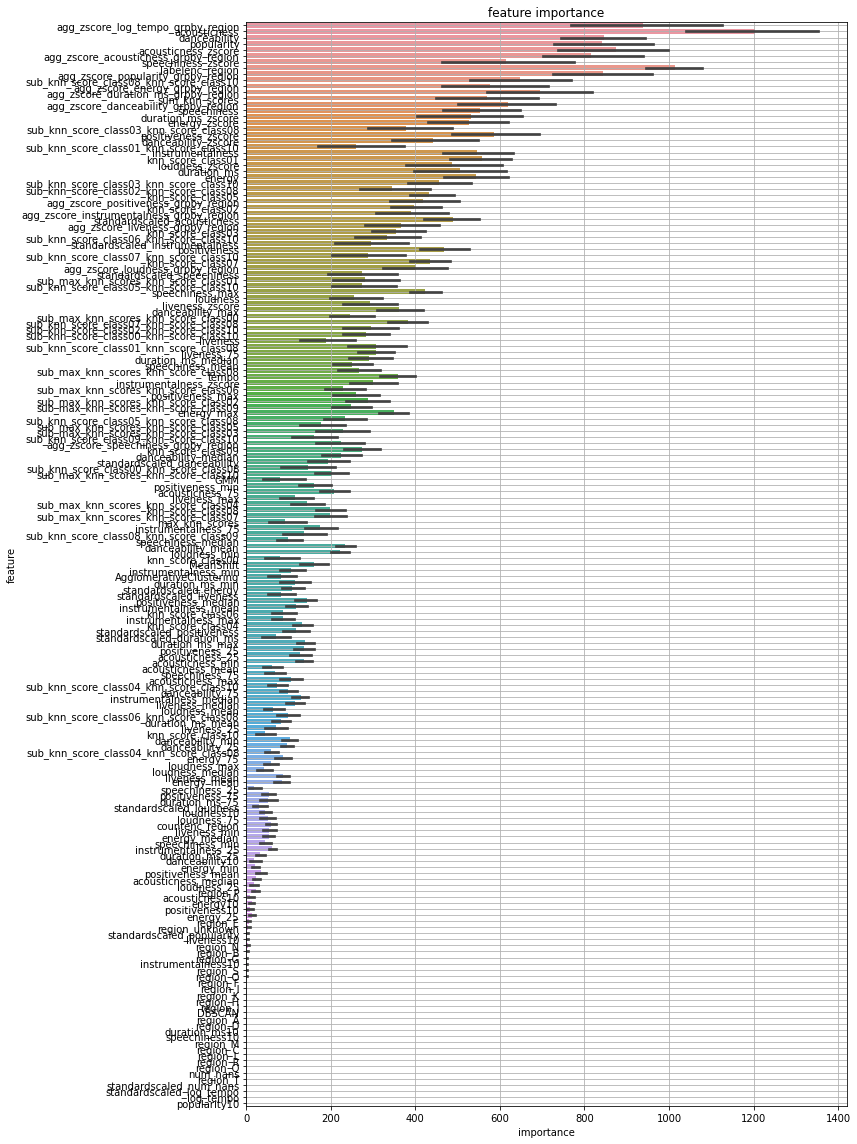

In [51]:
df_test["prediction"] = predictions.argmax(1)
score = f1_score(target, oof.argmax(1), average="macro")
print("CV score")
print(f"  f1: {score:8.5f}")
print()
print(classification_report(target, oof.argmax(1)))

plt.figure(figsize=(12, 16))
sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
plt.title("feature importance")
plt.grid()
plt.tight_layout()
plt.show()

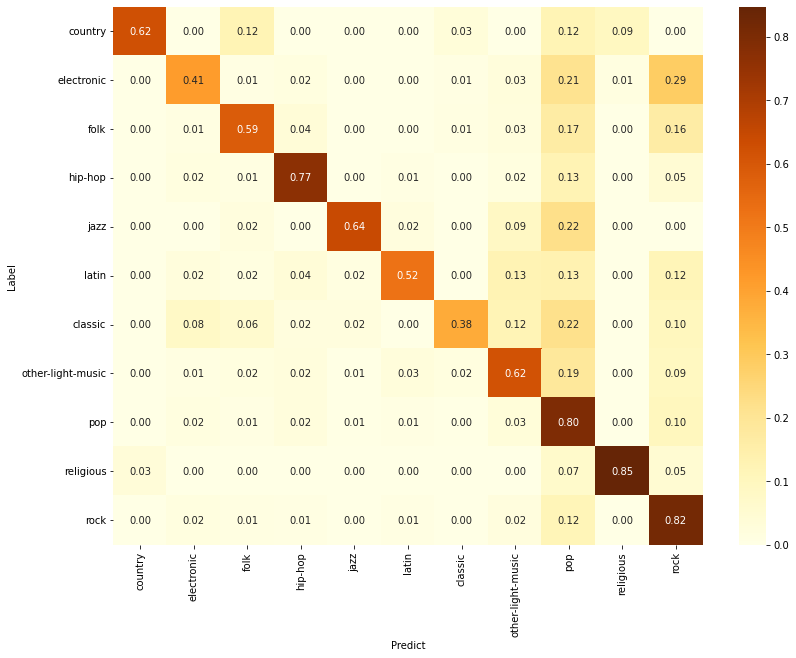

In [52]:
def visualize_confusion_matrix(y_true,
                               pred_label,
                               height=.6,
                               labels=None):  # from https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
    sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    return fig

oof_label = pd.Series(np.argmax(oof, axis=1))
fig = visualize_confusion_matrix(y_true=target, pred_label=oof_label, labels=df_genre_labels["genre"])
fig.show()

#サブミット

In [53]:
df_submission = df_sample_sub.copy()
df_submission["genre"] = df_submission["index"].map(dict(df_test[["index", "prediction"]].values))
assert not df_submission["genre"].isna().any()
display(df_submission.head(10))

# make submission file
df_submission.to_csv("submit-lgbm+kNN-cv5+pop10*region+GMM-2-hm.csv", header=None, index=False)

,index,genre
0,4046,7
1,4047,10
2,4048,10
3,4049,8
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,3
9,4055,10


In [54]:
! signate submit -c 565 -n "lgbm+kNN cv5 neibor=10 pop10*region + feature//10 cv + //target count encoding// + GMM at each validation as hearmonic mean" submit-lgbm+kNN-cv5+pop10*region+GMM-2-hm.csv

You have successfully submitted your predictions.We will send you the submission result to your email address.
